# Contents

1. [Topic Extraction](#1.-Topic-Extraction)  
    1.1. [Load sample](#1.1.-Load-sample)  
    1.2. [BERTopic](#1.2.-BERTopic)  
    1.3. [Latent Dirichlet Allocation (LDA)](#1.3.-Latent-Dirichlet-Allocation-(LDA))


# **1. Topic Extraction**

The goal of Topic Extraction (or Topic Modeling) is, as the name says, to automatically identify the most meaningul topics that describe the content of a document, toghether with the most representative keywords for each topic. This is a crucial task in our pipeline, because we want to know what politicians talk about, i.e. what are the possible axis that construct an opinion. For this, we will test two popular tools for topic extraction: **BERTopic** and **LDA**.

In [ ]:
!pip install -U numpy
!pip install pyldavis
!pip install bertopic

# !pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan
# !pip install --upgrade tbb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Load sample

In [ ]:
import pandas as pd

To load the datasets and execute the notebook, add a shortcut in MyDrive to [this folder](https://drive.google.com/drive/folders/1lvLMyLd9I3xoRwfghdVOgkTR4hKr76Vn?usp=sharing).

In [ ]:
# Get a preprocessed sample of the dataset, filtered only for quotes of 
# US modern politicians (cfr Data_Wrangling.ipynb)
samplepath_processed = '/content/drive/MyDrive/ADA/Processed/quotes-2020-sample.parquet.gzip'
df = pd.read_parquet(samplepath_processed)
print('Loaded %d sample quotations.'%len(df))

Loaded 9099 sample quotations.


In [ ]:
df.head(5)

,date,qids,quotation,speaker,urls,domains
0,2020-01-23 22:29:35,Q7687964,Correctional officers received higher pay over...,Tate Reeves,[https://yallpolitics.com/2020/01/23/governor-...,[yallpolitics.com]
1,2020-02-26 22:53:36,Q22686,Prime Minister Modi and President Trump commit...,President Donald Trump,[https://www.newkerala.com/news/2020/31253.htm],[newkerala.com]
2,2020-03-16 19:17:22,Q13562456,The forces of the status quo have been effecti...,Nina Turner,[http://p.washingtontimes.com/news/2020/mar/16...,"[p.washingtontimes.com, washingtontimes.com]"
3,2020-02-09 18:22:09,Q22686,The Trump administration has reversed almost a...,Donald Trump,[https://www.alternet.org/2020/02/white-house-...,[alternet.org]
4,2020-02-10 00:00:00,Q359442,You cannot take support to billionaires and th...,Bernie Sanders,[https://thiscantbehappening.net/the-red-baiti...,"[counterpunch.org, thiscantbehappening.net]"


## 1.2. BERTopic

**BERTopic** is an algorithm for topic extraction that builds on top of [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), a pretrained language representation model based on [transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) developed by Google and quickly becomed extremely popular for in the NLP community [[1]](https://arxiv.org/abs/1810.04805). 

BERTopic uses BERT to embed documents and then applies sequentially [UMAP](https://umap-learn.readthedocs.io/en/latest/), to reduce the dimensionality, and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/), to cluster semantically similar documents (i.e. create topics). Finally, topic representation is constructed with [c-TF-IDF](https://github.com/MaartenGr/cTFIDF).

The algorithm pipeline is showed schematically below [[2]](https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.html).

<img src="https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.png" width="700" height="600"/>

© Maarten Grootendorst 2021

In [ ]:
import time
from bertopic import BERTopic
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

Let's fit BERTopic to our sample, and predict the main topic of each quote. We will set the number of topics parameter of the model as 'auto', so that BERTopic automatically reduce topics with a high similarity.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

2021-11-12 14:43:17,662 - BERTopic - Transformed documents to Embeddings
2021-11-12 14:43:44,326 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 14:43:44,950 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 14:44:28,244 - BERTopic - Reduced number of topics from 123 to 76


BERTopic: Fitted and predicted topics from 9099 quotes in 4:07 min.


We can now see what are the first (in terms of quotes belonging to them) topics and get an idea of which words are associated to them. 

In [ ]:
# Get info about the first 10 extracted topics
topic_model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,4420,-1_president_health_an_these
1,0,269,0_students_school_education_schools
2,1,179,1_through_days_weeks_going
3,2,109,2_players_coach_basketball_playoffs
4,3,108,3_she_her_shes_pelosi
5,4,107,4_banks_loans_loan_financial
6,5,106,5_housing_city_mayor_downtown
7,6,88,6_iran_iranian_nuclear_sanctions
8,7,87,7_trump_donald_president_him
9,8,84,8_african_racism_latino_race


In [ ]:
topic_model.visualize_barchart(top_n_topics=9, width=800, height=800)

Intuitively, almost all these topics make sense in the context of US political debate and are easly human-intepretable: Education, basketball, Nancy Pelosi, banks, housing, Iran, Donald Trump, racism. Note that the topic -1 refers to all outliers and unmeaningful words, and contains almost half of the quotes.

In [ ]:
topic_model.get_topic_info().tail(10)

,Topic,Count,Name
66,65,16,65_bolton_subpoena_boltons_privilege
67,66,15,66_bipartisan_bicameral_support_version
68,67,14,67_decision_choice_difficult_spokane
69,68,13,68_books_book_potter_teens
70,69,13,69_cough_symptoms_fever_breathing
71,70,13,70_curve_flattening_bend_flat
72,71,13,71_fire_fires_wildfires_firefighters
73,72,13,72_belomorkanal_cuba_venezuela_prisoners
74,73,12,73_display_transparent_microled_brightness
75,74,12,74_cost_price_expensive_afford


Despite having a small amount of quotes for each, also the last (i.e. those with a fewest amount of quotes) topics seem to make sense.

In addition, we can visualize spacially the inter-topic distance.



In [ ]:
topic_model.visualize_topics()

This shows how correlated topics nicely cluster toghether. For example:
- Cluster all to the right of IV quadrant (candidates to the last elections)
  - Topic 7: trump | donald | president
  - Topic 24: bernie | sanders | progressive
  - Topic 25: biden | joe | candidate
  - Topic 59: bloomberg | bloombergs
- Cluster in bottom left of III quadrant (covid)
  - Topic 19: covid19 | covid | disease
  - Topic 20: virus | spread | spreading
  - Topic 16: coronavirus | health | threat
  - Topic 11: testing | test | labs
  - Topic 30: ventilators | beds | ventilator



On the other hand, a lot of topics are clustered toghether despite being apparently unrelated, and the reason is not immediately clear.


It is interesting to see that numerous quotations are related to news events or transient topics such as Iran nuclear deal, COVID, the 2020 election or Hillary Clinton's email affair. Such topics are dominant during a short time frame, but later lose most of their influence.

In [ ]:
topics_over_time = topic_model.topics_over_time(df.quotation, topics[0], df.date, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

20it [00:54,  2.71s/it]


From these topics, we can also generate word clouds. We will label each row with a topic and generate a word cloud aggregating all the quotes belonging to a certain topic. Before, we will remove some stop words from the sentences, but it is still likely that we will find a lot of useless words.

In [ ]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['topics'] = topics[0]
df_topics = df[df['topics'] != -1]
df_topics.head(5)

,date,qids,quotation,speaker,urls,domains,topics
0,2020-01-23 22:29:35,Q7687964,Correctional officers received higher pay over...,Tate Reeves,[https://yallpolitics.com/2020/01/23/governor-...,[yallpolitics.com],56
1,2020-02-26 22:53:36,Q22686,Prime Minister Modi and President Trump commit...,President Donald Trump,[https://www.newkerala.com/news/2020/31253.htm],[newkerala.com],21
3,2020-02-09 18:22:09,Q22686,The Trump administration has reversed almost a...,Donald Trump,[https://www.alternet.org/2020/02/white-house-...,[alternet.org],55
4,2020-02-10 00:00:00,Q359442,You cannot take support to billionaires and th...,Bernie Sanders,[https://thiscantbehappening.net/the-red-baiti...,"[counterpunch.org, thiscantbehappening.net]",75
5,2020-02-13 13:43:20,Q22686,"LOSER who has money but can't debate,",President Donald Trump,[https://www.mediaite.com/trump/trump-obsesses...,[mediaite.com],75


In [ ]:
def topic_wordcloud(topic, df):
  '''
  build wordcloud for the topic given as argument.
  '''
  stp = stopwords.words('english') 
  words = ''.join(df[df['topics'] == topic]['quotation'])
  return WordCloud(width=800, height=560,
                        background_color='white', collocations=False,
                        min_font_size=10, stopwords = stp).generate(words)

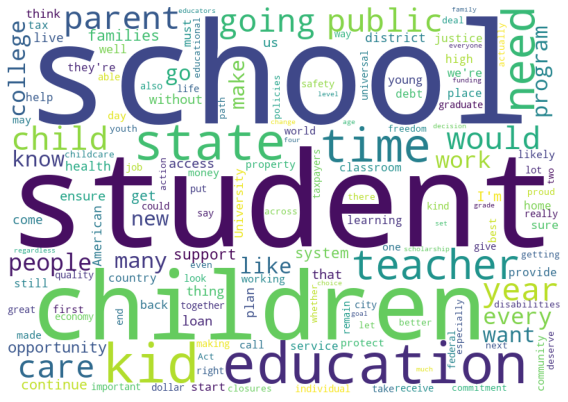

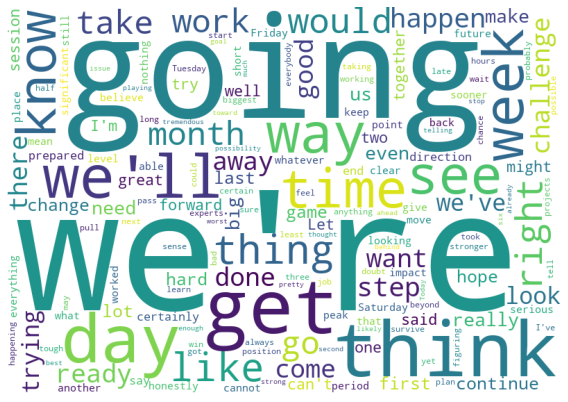

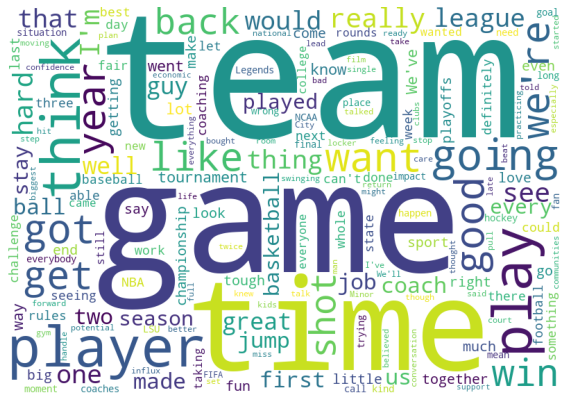

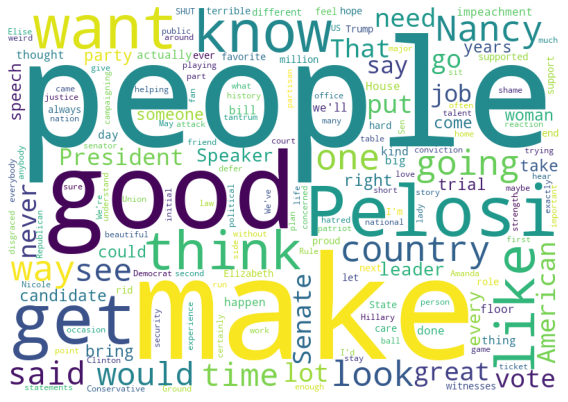

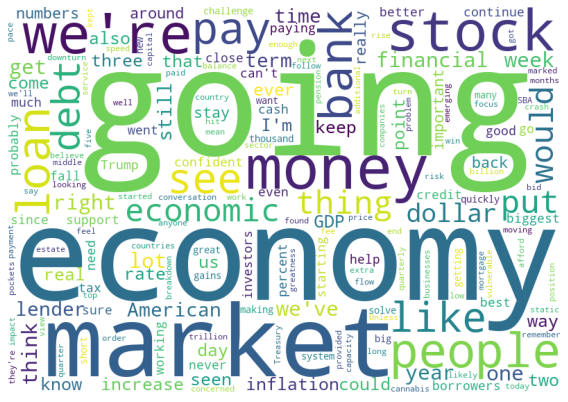

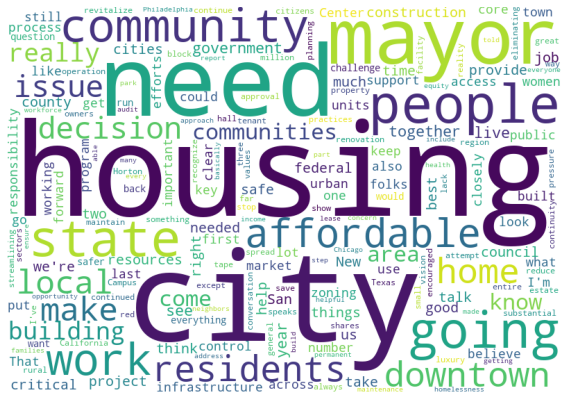

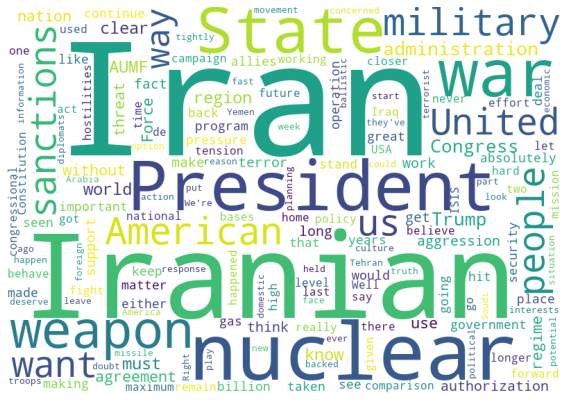

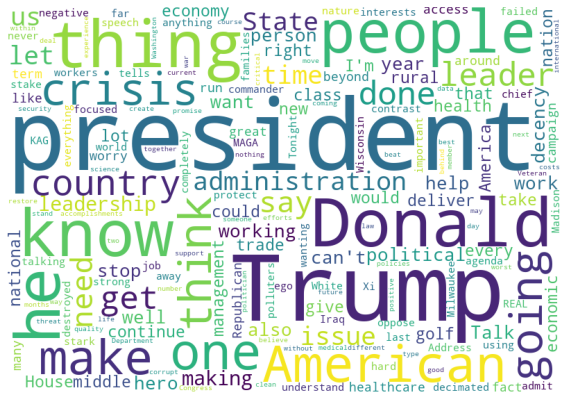

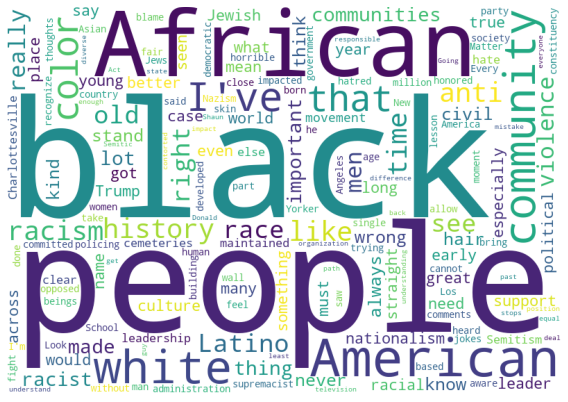

In [ ]:
counter = 0
for topic in topic_model.get_topics():
  if topic == -1:
    continue
  plt.figure(figsize=(8, 6), facecolor=None)
  wordcloud = topic_wordcloud(topic, df_topics)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show();
  print("") # Without this line, there is no space between plots
  counter += 1
  if(counter >= 9):
    break

Finally, to evaluate the performance of our model in topic extraction we can use a coherency metric [[3]](https://dl.acm.org/doi/10.1145/2684822.2685324), constructed to investigate how much sentences are _coherent_, i.e. how much they support each other. In short, the closer the coherence score is to 1, the better interpretable the topics are.

In [ ]:
# Snippet adapted from https://github.com/MaartenGr/BERTopic/issues/90#issuecomment-820915389

docs = df.quotation
# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics[0]})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics[0]))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
coherence

0.6392857037891492

According to literature, a coherence score of 0.65 is about as good as it gets for current topic extraction models, so the result obtained with BERTopic is promising.  
Next, we turn to LDA, the second topic extraction tool.

## 1.3. Latent Dirichlet Allocation (LDA)

**TODO: Rewrite explanation, textual descriptions, cleaning code**


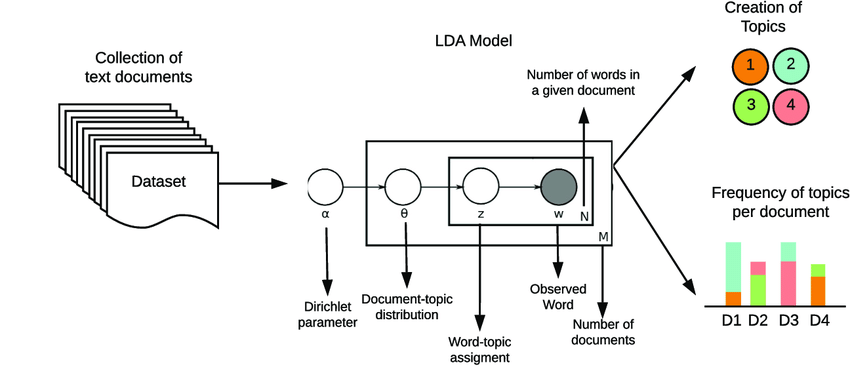


**Figure: overview of LDA model.** Taken from [Buenaño-Fernández et al. (2020).](https://www.researchgate.net/publication/339368709_Text_Mining_of_Open-Ended_Questions_in_Self-Assessment_of_University_Teachers_An_LDA_Topic_Modeling_Approach)



[Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html) is a generative Bayesian probabilistic model, which assumes that each quote in the dataset is a finite mixture over a set of $K$ unobserved topics. A topic is a multimodal distribution over all words in the vocabluary, making certain words to be more likely used within the context of a certain topic.

In particular, LDA assumes that each quote was generated with the following process: 
1. Draw a distribution over the topics, a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) distribution with parameter $\alpha$.
2. For each word in the document, draw a topic from the distribution found in [1], and draw the observed word from the selected topic.  

The parameters of the distributions must be learned from the data, which is  done with statistical learning (usually a Markov Chain Monte Carlo method).

Topic modeling with LDA requires a first step of preprocessing: we need to tokenize and lemmatize our documents. 

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatize_stemming(text):
    '''
    Lemmatisation and stemming of text.
    '''
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess_lda(text):
    '''
    Tokenize, remove stopwords, lemmatise and stem
    '''
    return [token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3]


In [ ]:
# Pre-processing example

test = "It's over Anakin, I have the high ground."
print('Original document: ', test, '\n')

tokens = gensim.utils.simple_preprocess(test)
print('Original document after tokenization: ', tokens, '\n')

print('Preprocessed document after tokenization and stopword removal: ', preprocess_lda(test))

Original document:  It's over Anakin, I have the high ground. 

Original document after tokenization:  ['it', 'over', 'anakin', 'have', 'the', 'high', 'ground'] 

Preprocessed document after tokenization and stopword removal:  ['anakin', 'high', 'ground']


In [ ]:
processed_quotes = df.quotation.map(preprocess_lda)
processed_quotes

0       [correctional, officers, received, higher, num...
1       [prime, minister, modi, president, trump, comm...
2       [forces, status, effective, portraying, term, ...
3       [trump, administration, reversed, progress, lo...
4                  [support, billionaires, going, people]
                              ...                        
9094                                         [calibrated]
9095     [care, coach, love, passion, choices, difficult]
9096    [email, murphy, supervalu, castletownbere, lis...
9097                       [america, envy, entire, world]
9098    [major, manufacturer, world, united, states, t...
Name: quotation, Length: 9099, dtype: object

Next thing is to convert each document into a word <-> id mapping with a dictionary. 

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_quotes)

In [ ]:
for k,v in dictionary.items():
  print('{} <-> {}'.format(k,v))
  if k>9: break

0 <-> commissioner
1 <-> correctional
2 <-> funding
3 <-> higher
4 <-> including
5 <-> increased
6 <-> increases
7 <-> kind
8 <-> number
9 <-> officers
10 <-> people


Then we need to convert the document into a Bag Of Words format.
It is a list of tuples (token_id, token_count) where token_id is the id of the word in the dictionary.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_quotes]
bow_corpus[0]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 2),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1)]

Then we need to compute the tf-idf representation of our data.

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
# Ignore deprecation warnings as the lib uses some deprecated APIs
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=100, id2word=dictionary, passes=50, workers=2, per_word_topics=True, random_state = 0)
lda_model_tfidf.show_topics()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



[(59,
  '0.023*"dealing" + 0.020*"society" + 0.018*"self" + 0.015*"space" + 0.014*"especially" + 0.014*"conflict" + 0.013*"drivers" + 0.012*"palestinian" + 0.010*"laid" + 0.010*"miss"'),
 (30,
  '0.020*"military" + 0.019*"force" + 0.016*"ensuring" + 0.016*"require" + 0.016*"attacks" + 0.016*"equal" + 0.015*"solve" + 0.015*"glad" + 0.014*"wish" + 0.012*"sooner"'),
 (67,
  '0.038*"virus" + 0.031*"spread" + 0.023*"haven" + 0.020*"remain" + 0.018*"market" + 0.015*"resources" + 0.014*"calm" + 0.014*"hopefully" + 0.013*"measures" + 0.011*"compliance"'),
 (86,
  '0.041*"court" + 0.023*"policies" + 0.023*"rule" + 0.021*"consider" + 0.019*"certain" + 0.016*"perfect" + 0.014*"supreme" + 0.013*"capital" + 0.011*"statements" + 0.010*"palestinians"'),
 (96,
  '0.045*"bernie" + 0.027*"housing" + 0.025*"sanders" + 0.018*"nominee" + 0.017*"private" + 0.016*"voters" + 0.014*"conversations" + 0.014*"officials" + 0.014*"attack" + 0.013*"ultimately"'),
 (14,
  '0.051*"feel" + 0.029*"knows" + 0.022*"like" 

Now that we have our topics, let's visualize them.

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
34     0.134945  0.021523       1        1  1.637107
99     0.108532  0.158483       2        1  1.633794
72     0.095900 -0.100226       3        1  1.561729
18     0.103489  0.059597       4        1  1.550969
70     0.113857  0.049884       5        1  1.482822
...         ...       ...     ...      ...       ...
49    -0.073618  0.007075      96        1  0.710325
77    -0.068548 -0.009322      97        1  0.685073
11    -0.059524  0.000057      98        1  0.681272
51    -0.071495  0.011467      99        1  0.643002
38    -0.072070  0.019426     100        1  0.625259

[100 rows x 5 columns], topic_info=          Term       Freq      Total  Category  logprob  loglift
429       deal  20.000000  20.000000   Default  30.0000  30.0000
80       needs  20.000000  20.000000   Default  29.0000  29.0000
182      party  21.000000  21.000000   Default  28.0000  28.0000
925       home  23.000000  23.000000   Default  27.0000  27.0000
573   happened  13.000000  13.000000   Default  26.0000  26.0000
...        ...        ...        ...       ...      ...      ...
1058  business   0.826295  20.409823  Topic100  -5.2068   1.8679
1346    school   0.631190  13.469702  Topic100  -5.4762   2.0142
89       start   0.602266  14.995088  Topic100  -5.5231   1.8600
144       know   0.695168  63.450145  Topic100  -5.3796   0.5609
1089   schools   0.523848   9.299906  Topic100  -5.6626   2.1982

[4262 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1278      6  0.552227  ability
1278      7  0.110445  ability
1278     35  0.110445  ability
1278     50  0.110445  ability
320       1  0.075543     able
...     ...       ...      ...
428      96  0.098989    young
2911     68  0.666907    youth
5018     82  0.703449  zealand
825      45  0.915818     zero
5765     80  0.592575     zone

[7998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[35, 100, 73, 19, 71, 5, 84, 89, 48, 6, 23, 10, 1, 18, 22, 68, 57, 14, 45, 37, 77, 82, 8, 74, 88, 97, 62, 90, 61, 53, 92, 34, 40, 75, 27, 99, 7, 59, 36, 64, 98, 94, 32, 86, 96, 76, 67, 13, 65, 56, 91, 47, 16, 26, 93, 31, 79, 95, 63, 42, 30, 83, 41, 54, 3, 85, 29, 49, 69, 4, 24, 38, 51, 20, 81, 70, 11, 72, 55, 2, 44, 60, 46, 87, 9, 25, 28, 17, 66, 33, 21, 15, 58, 80, 43, 50, 78, 12, 52, 39])

How well is our model performing ? 

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_quotes, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5703945055160119


This score of coherence is also quite good, but the topics do not seem as easy to interpret as BERTopic's ones.

# **2. Conclusion**

Comparing BERTopic and LDA, we have found BERTopic to provide very meaningful and easy to interpret topics, and evaluating its performances we found a pretty good coherence score. LDA gave also acceptable results, but the topics are not as easy to interpret and generally seem less meaningful. Also, the coherence score is slightly worse than in BERTopic.

For these reasons, we will use **BERTopic** as our tool for Topic Extraction for the rest of the project.

## 2.1. Feasibility

To evaluate the feasibility of our chosen tool, BERTopic, we will test again the time it takes to evaluate the sentiment on our sample dataset to get a better idea of its performances.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted and predicted topics from %d quotes in %i:%i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

2021-11-12 15:01:48,332 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-12 15:02:26,967 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:02:27,600 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:03:09,963 - BERTopic - Reduced number of topics from 122 to 72


BERTopic: Fitted and predicted topics from 9099 quotes in 4:17 min.


Taking almost 4:30 min on 9099 quotes, our filtered dataset of almost 12 milions quotes (US modern politicians) will take almost 100h to run. Arguably, the part which takes the most time is fitting to our model, so we will analyze separately the runtime of fitting and predicting topics.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

2021-11-12 15:06:06,443 - BERTopic - Transformed documents to Embeddings
2021-11-12 15:06:32,532 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:06:33,120 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:07:21,731 - BERTopic - Reduced number of topics from 132 to 86


BERTopic: Fitted from 9099 quotes in 4:11 min.


In [ ]:
start = time.time()
topics = topic_model.transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

BERTopic: Predicted topics from 9099 quotes in 2:57 min.


Despite the transform phase being shorter, this is not helping a lot in reducing the total time, even if we only fitted on a portion of our dataset. However, we can do much better if we work with a GPU instead of a CPU!

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

2021-11-12 15:28:59,200 - BERTopic - Transformed documents to Embeddings
2021-11-12 15:29:23,941 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:29:24,534 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:29:32,120 - BERTopic - Reduced number of topics from 123 to 80


BERTopic: Fitted from 9099 quotes in 0:54 min.


In [ ]:
start = time.time()
topics = topic_model.transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

BERTopic: Predicted topics from 9099 quotes in 0:10 min.


This is indeed much better, as we can just fit the model on a subset of our data (say the 25%, 3 milion quotes) and then predict separately the topics.
Doing so, we would need only 5 hours to fit and less than 4 hours for labeling quotes with topics.

These estimates are based on the assumption that these methods scale near linearly. Since it's not clear from the documentation, we will test ourselves how the time varies with datasets of different sizes.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/285 [00:00<?, ?it/s]

2021-11-12 15:27:57,481 - BERTopic - Transformed documents to Embeddings
2021-11-12 15:28:21,665 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:28:22,278 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:28:30,373 - BERTopic - Reduced number of topics from 132 to 81


BERTopic GPU: Fitted and predicted topics from 9099 quotes in 0:54 min.


In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
df_short = df[:len(df) // 2]
start = time.time()
topics = topic_model.fit_transform(df_short.quotation)
# topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df_short), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

2021-11-12 15:18:58,308 - BERTopic - Transformed documents to Embeddings
2021-11-12 15:19:11,853 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:19:12,520 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:19:16,162 - BERTopic - Reduced number of topics from 59 to 37


BERTopic GPU: Fitted and predicted topics from 4549 quotes in 0:34 min.


In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
df_short = df[:len(df) // 10]
start = time.time()
topics = topic_model.fit_transform(df_short.quotation)
# topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df_short), time_elapsed // 60, time_elapsed % 60))

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

2021-11-12 15:19:45,616 - BERTopic - Transformed documents to Embeddings
2021-11-12 15:19:56,267 - BERTopic - Reduced dimensionality with UMAP
2021-11-12 15:19:56,332 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-12 15:19:57,032 - BERTopic - Reduced number of topics from 8 to 8


BERTopic GPU: Fitted and predicted topics from 909 quotes in 0:24 min.


We can see clearly that transforming documents to embeddings scales exactly linearly. The other costly step is reducing dimensionality with UMAP, which is known to perform slightly worse than linear, approaching empirically something close to $O(n^{1.14})$ [[3]](https://umap-learn.readthedocs.io/en/latest/benchmarking.html)[[4]](https://github.com/lmcinnes/umap/issues/8#issuecomment-343693402).